In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

# data preprocessing
import nltk
nltk.download('stopwords')
# nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder, StandardScaler
# # Model Building
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, roc_auc_score
from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
os.listdir("/kaggle/input/spam-sms-classification-using-nlp/")

['Spam_SMS.csv']

In [3]:
data = pd.read_csv("/kaggle/input/spam-sms-classification-using-nlp/Spam_SMS.csv", encoding='latin-1')

In [4]:
data = data.rename(columns= {
    'ï»¿Class':'Class',
    'Message':'Message'
});

In [5]:
data.head(5)

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data.columns

Index(['Class', 'Message'], dtype='object')

In [7]:
data.shape

(5574, 2)

In [8]:
data.isnull().sum()

Class      0
Message    0
dtype: int64

In [9]:
data['Class'].value_counts()

Class
ham     4827
spam     747
Name: count, dtype: int64

In [10]:
data.duplicated().sum()

415

In [11]:
data = data.drop_duplicates(keep='first')
data['Class'].value_counts()

Class
ham     4518
spam     641
Name: count, dtype: int64

In [12]:
data.shape

(5159, 2)

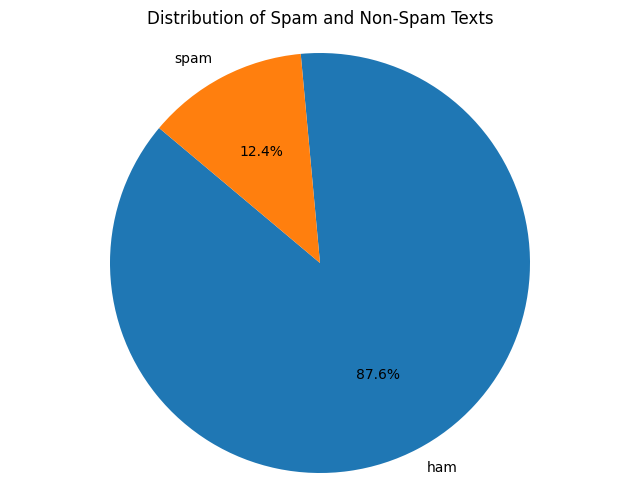

In [13]:
plt.figure(figsize=(8, 6))
plt.pie(data['Class'].value_counts(), labels=data['Class'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam Texts')
plt.axis('equal') 
plt.show()

In [14]:
data['Transformed_Text'] = data['Message'].str.lower()
data['Transformed_Text'] = data['Transformed_Text'].apply(word_tokenize)
data['Transformed_Text'] = data['Transformed_Text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])
stop_words = set(stopwords.words('english'))

clean_words = lambda x: [word for word in x if word not in stop_words and word not in string.punctuation]
data['Transformed_Text'] = data['Transformed_Text'].apply(clean_words)

ps = PorterStemmer()
data['Transformed_Text'] = data['Transformed_Text'].apply(lambda x: [ ps.stem(word) for word in x ])

data['Transformed_Text'] = data['Transformed_Text'].apply(lambda x: ' '.join(x))

data.head(5)

,Class,Message,Transformed_Text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think goe usf live around though


In [15]:
def avg_word_length(string):
    # print(string)
    cleaned_words_lengths = []
    for word in string.split(' '):
        cleaned_words_lengths.append(len(re.sub(r'[^a-zA-Z0-9\s]', '', word)))

    return sum(cleaned_words_lengths)/len(cleaned_words_lengths)

def unique_words_count(string):
    unique_words = []
    for word in string.split(' '):
        clean_word = re.sub(r'[^a-zA-Z0-9\s]', '', word)
        if clean_word not in unique_words:
            unique_words.append(clean_word)

    return len(unique_words)

def contains_link(string):
    url_pattern = r'https?://\S+|www\.\S+'
    return bool(re.search(url_pattern, string))

def count_capitalized_words(string):
    words = string.split(' ')
    count = 0
    for word in words:
        if len(word) != 0 and word[0].isupper():
            count +=1
    return count

def contains_uppercase_words(string):
    words = string.split(' ')
    for word in words:
        if word.isupper():
            return True
    return False

def contains_money_symbol(string):
    # Regex pattern to check for common money symbols
    pattern = r'[\u0024\u20AC\u00A3\u00A5\u20B9\u20A0\u20B1\u20A3\u20AA\u20B4\u20B8\u20BF\u00A2\u20A4\u20B5\u20C0\u20A7\u20B6\u20AA\u20B2\u20B7\u20B3\u20B0\u20A8\u20A1\u20A2\u20C3]'
    return bool(re.search(pattern, string))

def number_of_positive_words(string):
    positive_words = [
    'awesome', 'amazing', 'fantastic', 'great', 'good', 'wonderful',
    'excellent', 'fabulous', 'brilliant', 'outstanding', 'terrific',
    'superb', 'happy', 'joyful', 'cheerful', 'delighted', 'pleased',
    'content', 'positive', 'love', 'loved', 'lovely', 'like', 'liked',
    'enjoy', 'enjoyed', 'excited', 'hopeful', 'friendly', 'kind',
    'nice', 'grateful', 'thankful', 'blessed', 'motivated', 'inspired',
    'enthusiastic', 'confident', 'strong', 'smart', 'creative', 'fun',
    'funny', 'laugh', 'beautiful', 'gorgeous', 'handsome', 'cute',
    'cool', 'charming', 'adorable', 'sweet', 'awesome', 'genius',
    'honest', 'helpful', 'peaceful', 'calm', 'relaxed', 'rich',
    'successful', 'winner', 'victory', 'yay', 'yes', 'accomplished',
    'proud', 'satisfied', 'smile', 'smiling', 'supportive', 'trustworthy',
    'warm', 'caring', 'positive', 'optimistic', 'sunny', 'bright'
    ]

    count = 0
    for word in string.split(' '):
        if word.lower() in positive_words:
            count +=1
    return count


def number_of_negative_words(string):
    negative_words = [
    'bad', 'worse', 'worst', 'awful', 'terrible', 'horrible', 'hate', 'hated',
    'dislike', 'angry', 'mad', 'sad', 'unhappy', 'upset', 'annoyed', 'frustrated',
    'depressed', 'miserable', 'unpleasant', 'disgusting', 'gross', 'sucks',
    'lame', 'stupid', 'dumb', 'ugly', 'nasty', 'mean', 'rude', 'hurt', 'hurts',
    'pain', 'painful', 'failure', 'fail', 'loser', 'problem', 'problems',
    'weak', 'anxious', 'scared', 'fear', 'afraid', 'worry', 'worried',
    'hopeless', 'worthless', 'pathetic', 'annoying', 'disappointed',
    'hate', 'kill', 'killed', 'killing', 'broken', 'break', 'broke',
    'no', 'not', 'never', 'nothing', 'nowhere', 'can\'t', 'won\'t', 'shouldn\'t',
    'don’t', 'didn’t', 'wouldn’t', 'couldn’t', 'ugh', 'ew', 'ugh', 'yuck',
    'reject', 'rejected', 'liar', 'lies', 'cry', 'cried', 'crying',
    'failures', 'insecure', 'jealous', 'envy', 'resent', 'rage'
        ]
    count = 0
    for word in string.split(' '):
        if word.lower() in negative_words:
            count +=1
    return count

def contains_mobile_number(string):
    for word in string.split(' '):
        if word.isdigit():
            if len(word) == 11 or len(word)==10:
                return True
    return False

In [16]:
data['length'] = data['Message'].apply(lambda x: len(x) )
data['word_count'] = data['Message'].apply(lambda x: len(x.split(' ')))
data['avg_word_length'] = data['Message'].apply(avg_word_length)
data['unique_words_count'] = data['Message'].apply(unique_words_count)

data['number_of_exclamations'] = data['Message'].apply(lambda x: x.count('!'))
data['number_of_questions'] = data['Message'].apply(lambda x: x.count('?'))

data['number_of_punctuations'] = data['Message'].apply(lambda x: sum(1 for char in x if char in string.punctuation))

data['has_link'] = data['Message'].apply(contains_link)

data['num_capitalized_words'] = data['Message'].apply(count_capitalized_words)
data['has_all_caps_word'] = data['Message'].apply(contains_uppercase_words)

data['has_money_symbol'] = data['Message'].apply(contains_money_symbol)

data['number_of_positive_words'] = data['Transformed_Text'].apply(number_of_positive_words)

data['number_of_negative_words'] = data['Transformed_Text'].apply(number_of_negative_words)

data['has_mobile_number'] = data['Transformed_Text'].apply(contains_mobile_number)

data.head()

,Class,Message,Transformed_Text,length,word_count,avg_word_length,unique_words_count,number_of_exclamations,number_of_questions,number_of_punctuations,has_link,num_capitalized_words,has_all_caps_word,has_money_symbol,number_of_positive_words,number_of_negative_words,has_mobile_number
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,111,20,4.150000,20,0,0,9,False,3,False,False,1,0,False
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,29,6,3.000000,6,0,0,6,False,2,False,False,0,0,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...,155,28,4.357143,24,0,0,6,False,6,True,False,0,0,False
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,49,11,3.000000,9,0,0,6,False,2,True,False,0,0,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think goe usf live around though,61,13,3.615385,12,0,0,2,False,2,True,False,0,0,False


In [17]:
!pip install vaderSentiment

In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores 

In [19]:
sentiment_scores = data['Transformed_Text'].apply(get_vader_sentiment)

In [20]:
compound_sentiment_scores = []
for d in sentiment_scores:
    compound_sentiment_scores.append(d['compound'])

data['sentiment_scores'] = compound_sentiment_scores

data.head()

,Class,Message,Transformed_Text,length,word_count,avg_word_length,unique_words_count,number_of_exclamations,number_of_questions,number_of_punctuations,has_link,num_capitalized_words,has_all_caps_word,has_money_symbol,number_of_positive_words,number_of_negative_words,has_mobile_number,sentiment_scores
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,111,20,4.150000,20,0,0,9,False,3,False,False,1,0,False,0.8442
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,29,6,3.000000,6,0,0,6,False,2,False,False,0,0,False,0.5267
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...,155,28,4.357143,24,0,0,6,False,6,True,False,0,0,False,0.7964
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,49,11,3.000000,9,0,0,6,False,2,True,False,0,0,False,0.0000
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think goe usf live around though,61,13,3.615385,12,0,0,2,False,2,True,False,0,0,False,-0.1027


In [21]:
spam_texts = data[data['Class'] == 'spam']['Transformed_Text']

spam_words = ' '.join(spam_texts).split()

spam_words_filtered = [word for word in spam_words if not word.isdigit()]

spam_words_counts = Counter(spam_words_filtered)

spam_most_common_words = spam_words_counts.most_common(20)

spam_most_common_words

[('call', 314),
 ('free', 186),
 ('txt', 139),
 ('u', 133),
 ('text', 122),
 ('ur', 119),
 ('mobil', 110),
 ('stop', 108),
 ('repli', 102),
 ('claim', 97),
 ('prize', 79),
 ('get', 73),
 ('new', 64),
 ('servic', 64),
 ('send', 60),
 ('tone', 59),
 ('urgent', 57),
 ('award', 55),
 ('nokia', 54),
 ('contact', 54)]

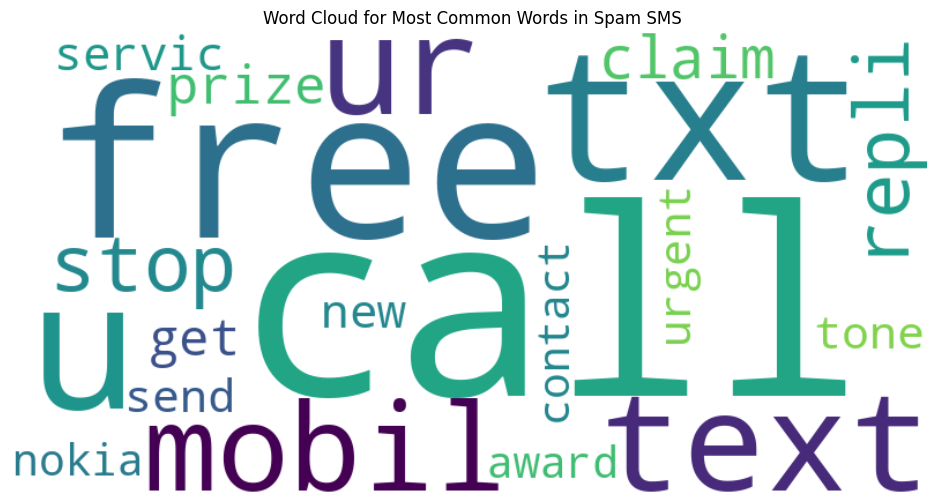

In [22]:
wordCloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(spam_most_common_words))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam SMS')
plt.axis('off')
plt.show()

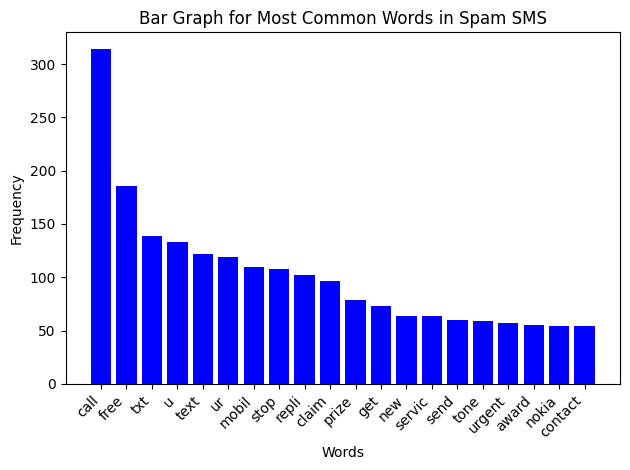

In [23]:
words, counts = zip(*spam_most_common_words)

plt.bar(words, counts, color='blue')
plt.title('Bar Graph for Most Common Words in Spam SMS')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
ham_texts = data[data['Class'] == 'ham']['Transformed_Text']

ham_words = ' '.join(ham_texts).split()

ham_words_filtered = [word for word in ham_words if not word.isdigit()]

words_counts_ham = Counter(ham_words_filtered)

most_common_ham_words = words_counts_ham.most_common(20)

most_common_ham_words

[('u', 919),
 ('go', 407),
 ('nt', 355),
 ('get', 352),
 ('gt', 288),
 ('lt', 287),
 ('come', 278),
 ('ok', 252),
 ('got', 239),
 ('know', 237),
 ('like', 236),
 ('call', 236),
 ('love', 222),
 ('time', 220),
 ('good', 215),
 ('want', 209),
 ('ur', 203),
 ('day', 196),
 ('need', 172),
 ('one', 166)]

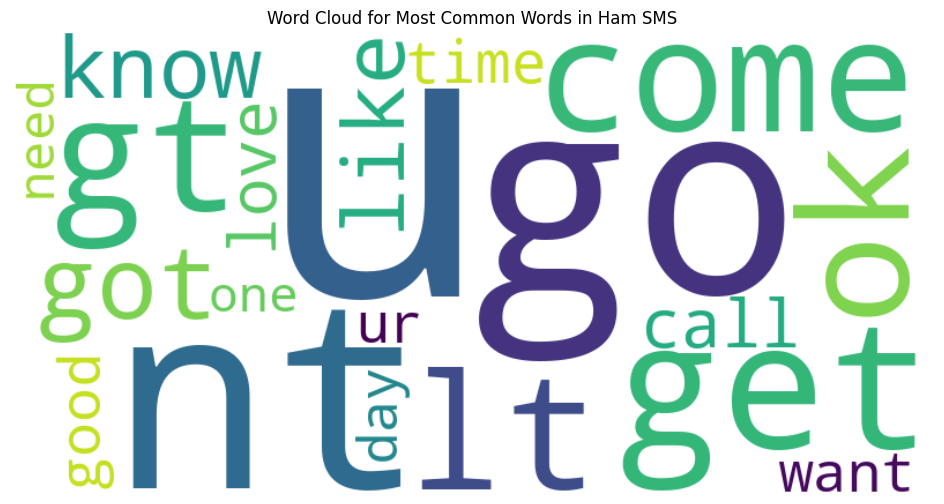

In [25]:
wordCloudHam = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_ham_words))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloudHam, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Ham SMS')
plt.axis('off')
plt.show()

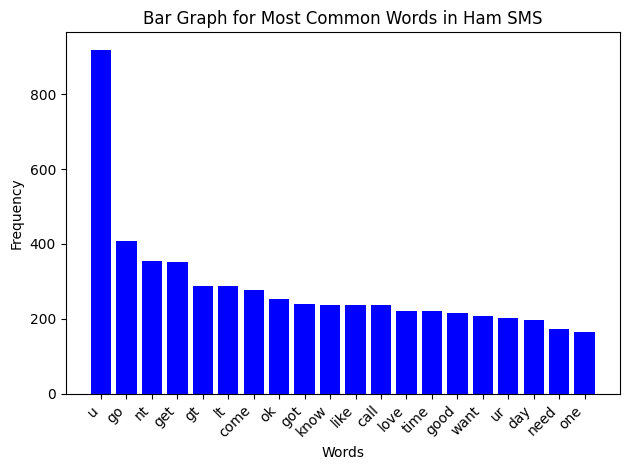

In [26]:
words, counts = zip(*most_common_ham_words)

plt.bar(words, counts, color='blue')
plt.title('Bar Graph for Most Common Words in Ham SMS')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
#Using Bag of Words
textMessages = data['Transformed_Text']
X_train, X_test, y_train, y_test = train_test_split(textMessages, data['Class'] , test_size=0.2, random_state=42)

In [28]:
data_train_subset = pd.DataFrame()
data_train_subset['Class'] = y_train
data_train_subset['Transformed_Text'] = X_train

data_train_subset.head()

,Class,Transformed_Text
1130,ham,check error difficulti correct
5060,spam,free video camera phone half price line rental...
3792,spam,twink bear scalli skin jock call nt miss weeke...
3118,ham,free call pa
99,ham,see cup coffe anim


In [29]:
spam_texts_train = data_train_subset[data_train_subset['Class'] == 'spam']['Transformed_Text']

spam_words_train = ' '.join(spam_texts_train).split()

# digits = [word for word in spam_words_train if word.isdigit()]

spam_words_filtered_train = [word for word in spam_words_train if not word.isdigit()]

spam_words_counts_train = Counter(spam_words_filtered_train)

spam_most_common_words_train = spam_words_counts_train.most_common(10)
spam_most_common_words_train

[('call', 248),
 ('free', 153),
 ('txt', 116),
 ('u', 109),
 ('text', 102),
 ('ur', 102),
 ('repli', 93),
 ('stop', 88),
 ('mobil', 83),
 ('claim', 75)]

In [30]:
list_of_scam_words = ['call','free', 'text','repli','stop','mobil','claim']

for word in list_of_scam_words:
    data['spam_'+word] = data['Transformed_Text'].apply(lambda x: word in x)

data.head()

,Class,Message,Transformed_Text,length,word_count,avg_word_length,unique_words_count,number_of_exclamations,number_of_questions,number_of_punctuations,...,number_of_negative_words,has_mobile_number,sentiment_scores,spam_call,spam_free,spam_text,spam_repli,spam_stop,spam_mobil,spam_claim
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,111,20,4.150000,20,0,0,9,...,0,False,0.8442,False,False,False,False,False,False,False
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,29,6,3.000000,6,0,0,6,...,0,False,0.5267,False,False,False,False,False,False,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...,155,28,4.357143,24,0,0,6,...,0,False,0.7964,False,True,True,False,False,False,False
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,49,11,3.000000,9,0,0,6,...,0,False,0.0000,False,False,False,False,False,False,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think goe usf live around though,61,13,3.615385,12,0,0,2,...,0,False,-0.1027,False,False,False,False,False,False,False


In [31]:
data.columns

Index(['Class', 'Message', 'Transformed_Text', 'length', 'word_count',
       'avg_word_length', 'unique_words_count', 'number_of_exclamations',
       'number_of_questions', 'number_of_punctuations', 'has_link',
       'num_capitalized_words', 'has_all_caps_word', 'has_money_symbol',
       'number_of_positive_words', 'number_of_negative_words',
       'has_mobile_number', 'sentiment_scores', 'spam_call', 'spam_free',
       'spam_text', 'spam_repli', 'spam_stop', 'spam_mobil', 'spam_claim'],
      dtype='object')

In [32]:
encoder = LabelEncoder()
data['Class'] = encoder.fit_transform(data['Class'])
data['has_link'] = encoder.fit_transform(data['has_link'])
data['has_all_caps_word'] = encoder.fit_transform(data['has_all_caps_word'])
data['has_money_symbol'] = encoder.fit_transform(data['has_money_symbol'])
data['has_mobile_number'] = encoder.fit_transform(data['has_mobile_number'])
data['spam_call'] = encoder.fit_transform(data['spam_call'])
data['spam_free'] = encoder.fit_transform(data['spam_free'])
data['spam_text'] = encoder.fit_transform(data['spam_text'])
data['spam_repli'] = encoder.fit_transform(data['spam_repli'])
data['spam_stop'] = encoder.fit_transform(data['spam_stop'])
data['spam_mobil'] = encoder.fit_transform(data['spam_mobil'])
data['spam_claim'] = encoder.fit_transform(data['spam_claim'])

data.head()

,Class,Message,Transformed_Text,length,word_count,avg_word_length,unique_words_count,number_of_exclamations,number_of_questions,number_of_punctuations,...,number_of_negative_words,has_mobile_number,sentiment_scores,spam_call,spam_free,spam_text,spam_repli,spam_stop,spam_mobil,spam_claim
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,111,20,4.150000,20,0,0,9,...,0,0,0.8442,0,0,0,0,0,0,0
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni,29,6,3.000000,6,0,0,6,...,0,0,0.5267,0,0,0,0,0,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...,155,28,4.357143,24,0,0,6,...,0,0,0.7964,0,1,1,0,0,0,0
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,49,11,3.000000,9,0,0,6,...,0,0,0.0000,0,0,0,0,0,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",nah nt think goe usf live around though,61,13,3.615385,12,0,0,2,...,0,0,-0.1027,0,0,0,0,0,0,0


In [33]:
artificial_features = data.columns[3:]

In [36]:
numerical_features = [ column for column in data.columns if data[column].dtype in ['int64', 'float64'] and column != 'Class' and data[column].nunique() > 2]

binary_features = [column for column in data.columns if data[column].nunique() <= 2 and column != 'Class']


In [37]:
numerical_features_data = data[numerical_features]
labels = data['Class']

auc_scores = []
for column in numerical_features_data.columns:
    x_col = numerical_features_data[[column]]
    model = LogisticRegression(solver='liblinear')
    model.fit(x_col, labels)
    preds = model.predict_proba(x_col)[:, 1]
    auc = roc_auc_score(labels, preds)
    auc_scores.append({'feature': column, 'score': auc})

auc_df = pd.DataFrame(auc_scores).sort_values(by='score', ascending=False)
auc_df

,feature,score
7,num_capitalized_words,0.883463
0,length,0.873181
3,unique_words_count,0.830583
2,avg_word_length,0.825315
1,word_count,0.810321
6,number_of_punctuations,0.690581
4,number_of_exclamations,0.676312
10,sentiment_scores,0.647181
8,number_of_positive_words,0.527905
5,number_of_questions,0.522516


In [38]:
from sklearn.feature_selection import chi2

chi2_scores, p_values = chi2(data[binary_features], data['Class'])

chi2_df = pd.DataFrame({
    'feature': binary_features,
    'score': chi2_scores,
    'p_value': p_values,
    'type': 'categorical'
}).sort_values(by='score', ascending=False)

chi2_df

,feature,score,p_value,type
3,has_mobile_number,2126.635535,0.000000e+00,categorical
2,has_money_symbol,1350.669531,1.102002e-295,categorical
4,spam_call,903.738573,1.510434e-198,categorical
9,spam_mobil,774.671249,1.734195e-170,categorical
5,spam_free,755.967407,2.022456e-166,categorical
10,spam_claim,676.642746,3.589348e-149,categorical
0,has_link,597.216399,6.749268e-132,categorical
8,spam_stop,455.983585,3.597002e-101,categorical
6,spam_text,403.055019,1.190972e-89,categorical
7,spam_repli,383.623982,2.022894e-85,categorical


In [39]:
combined = pd.concat([auc_df, chi2_df], ignore_index=True)
combined

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,feature,score,p_value,type
0,num_capitalized_words,0.883463,NaN,NaN
1,length,0.873181,NaN,NaN
2,unique_words_count,0.830583,NaN,NaN
3,avg_word_length,0.825315,NaN,NaN
4,word_count,0.810321,NaN,NaN
5,number_of_punctuations,0.690581,NaN,NaN
6,number_of_exclamations,0.676312,NaN,NaN
7,sentiment_scores,0.647181,NaN,NaN
8,number_of_positive_words,0.527905,NaN,NaN
9,number_of_questions,0.522516,NaN,NaN


In [40]:
combined['normal_score'] = (combined['score'] - combined['score'].min()) / (combined['score'].max() - combined['score'].min())
combined_sorted = combined.sort_values(by='normal_score', ascending=False)
combined_sorted.head(10)

,feature,score,p_value,type,normal_score
11,has_mobile_number,2126.635535,0.000000e+00,categorical,1.000000
12,has_money_symbol,1350.669531,1.102002e-295,categorical,0.635031
13,spam_call,903.738573,1.510434e-198,categorical,0.424821
14,spam_mobil,774.671249,1.734195e-170,categorical,0.364115
15,spam_free,755.967407,2.022456e-166,categorical,0.355318
16,spam_claim,676.642746,3.589348e-149,categorical,0.318008
17,has_link,597.216399,6.749268e-132,categorical,0.280650
18,spam_stop,455.983585,3.597002e-101,categorical,0.214223
19,spam_text,403.055019,1.190972e-89,categorical,0.189328
20,spam_repli,383.623982,2.022894e-85,categorical,0.180189


In [41]:
top_features = combined_sorted.head(10)['feature'].tolist()
top_features

['has_mobile_number',
 'has_money_symbol',
 'spam_call',
 'spam_mobil',
 'spam_free',
 'spam_claim',
 'has_link',
 'spam_stop',
 'spam_text',
 'spam_repli']

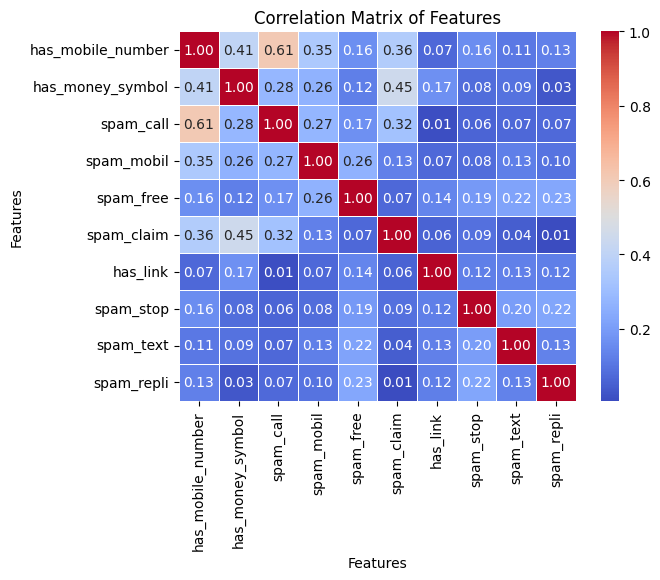

In [42]:
correlation_matrix = data[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

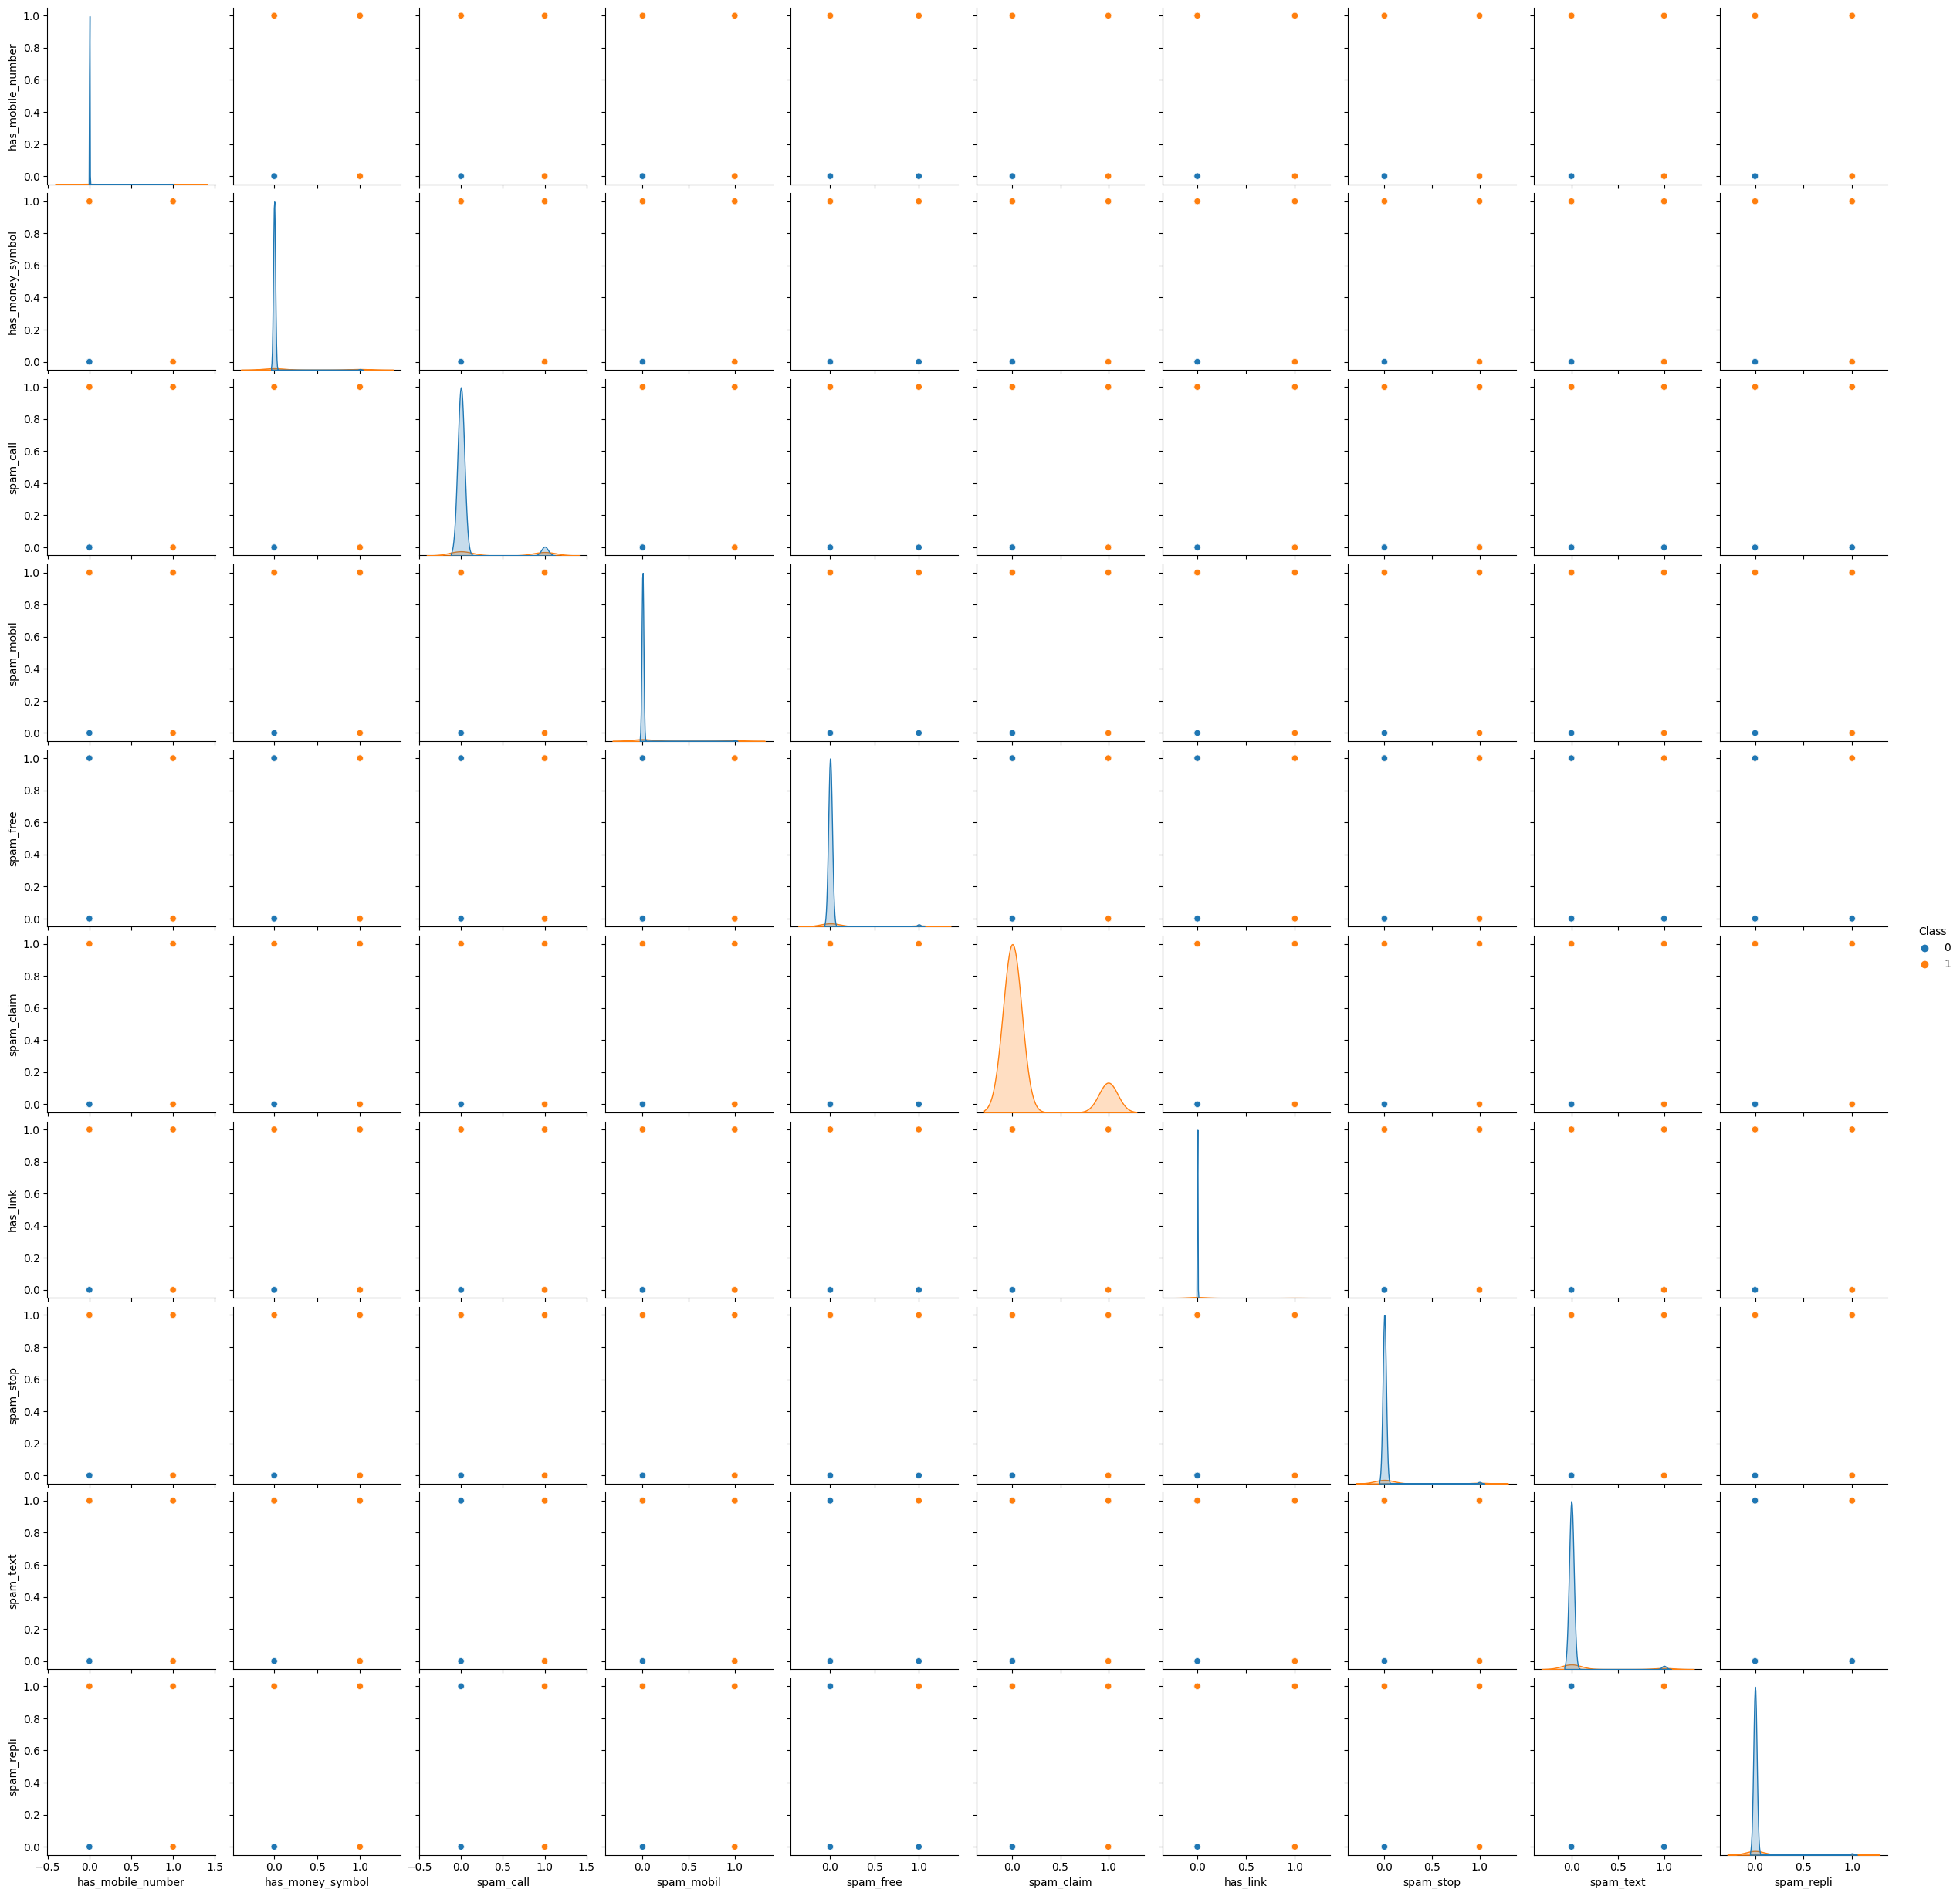

In [43]:
sns.pairplot(
    data,
    x_vars = top_features,
    y_vars = top_features,
    hue='Class'
)
plt.show()

In [53]:
X_train_BoW, X_test_BoW, y_train_BoW, y_test_BoW = train_test_split(data['Transformed_Text'], data['Class'] , test_size=0.2, random_state=42)

In [54]:
# Bag of words Vectorization

vectorizerCV = CountVectorizer()

X_train_BoW = vectorizerCV.fit_transform(X_train_BoW)
print("X_train shape:", X_train.shape)
print("X_train_BoW shape:", X_train_BoW.shape)

X_train shape: (4127,)
X_train_BoW shape: (4127, 6748)


In [55]:
accuracy_data_NB = {}
accuracy_data_SVC = {}

In [56]:
bernoulliNB_BoW = BernoulliNB()
bernoulliNB_BoW.fit(X_train_BoW, y_train_BoW)

X_test_BoW = vectorizerCV.transform(X_test_BoW)
predictions_BoW = bernoulliNB_BoW.predict(X_test_BoW)

accuracy_BoW = accuracy_score(y_test_BoW, predictions_BoW)

accuracy_data_NB['BoW'] = accuracy_BoW

print(accuracy_BoW)

confusionMatrix = confusion_matrix(y_test_BoW,predictions_BoW)

print(confusionMatrix)

print(classification_report(y_test_BoW, predictions_BoW, target_names=['ham','spam']))

0.9728682170542635
[[911   0]
 [ 28  93]]
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       911
        spam       1.00      0.77      0.87       121

    accuracy                           0.97      1032
   macro avg       0.99      0.88      0.93      1032
weighted avg       0.97      0.97      0.97      1032



In [57]:
svcClassifier_BoW = SVC()

svcClassifier_BoW.fit(X_train_BoW, y_train_BoW)

predictionsSVC_BoW = svcClassifier_BoW.predict(X_test_BoW)

print(accuracy_score(y_test_BoW, predictionsSVC_BoW))

accuracy_data_SVC['BoW'] = accuracy_score(y_test_BoW, predictionsSVC_BoW)

print(confusion_matrix(y_test_BoW, predictionsSVC_BoW))

print(classification_report(y_test_BoW, predictionsSVC_BoW, target_names=['ham','spam']))

0.9786821705426356
[[909   2]
 [ 20 101]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       911
        spam       0.98      0.83      0.90       121

    accuracy                           0.98      1032
   macro avg       0.98      0.92      0.94      1032
weighted avg       0.98      0.98      0.98      1032



In [58]:
top_features_data = data[top_features]

X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(top_features_data, data['Class'] , test_size=0.2, random_state=42)

In [59]:
bernoulliNB_top = BernoulliNB()
bernoulliNB_top.fit(X_train_top, y_train_top)

predictions_top = bernoulliNB_top.predict(X_test_top)

accuracy_top = accuracy_score(y_test_top, predictions_top)
print(accuracy_top)

accuracy_data_NB['Top'] =  accuracy_score(y_test_top, predictions_top)

confusionMatrix_top = confusion_matrix(y_test_top,predictions_top)

print(confusionMatrix_top)

print(classification_report(y_test_top, predictions_top, target_names=['ham','spam']))

0.9612403100775194
[[895  16]
 [ 24  97]]
              precision    recall  f1-score   support

         ham       0.97      0.98      0.98       911
        spam       0.86      0.80      0.83       121

    accuracy                           0.96      1032
   macro avg       0.92      0.89      0.90      1032
weighted avg       0.96      0.96      0.96      1032



In [61]:
svcClassifier_top = SVC()

svcClassifier_top.fit(X_train_top, y_train_top)

predictionsSVC_top = svcClassifier_top.predict(X_test_top)

accuracy_data_SVC['Top'] = accuracy_score(y_test_top, predictionsSVC_top)

print(accuracy_score(y_test_top, predictionsSVC_top))

print(confusion_matrix(y_test_top, predictionsSVC_top))

print(classification_report(y_test_top, predictionsSVC_top, target_names=['ham','spam']))

0.9641472868217055
[[899  12]
 [ 25  96]]
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       911
        spam       0.89      0.79      0.84       121

    accuracy                           0.96      1032
   macro avg       0.93      0.89      0.91      1032
weighted avg       0.96      0.96      0.96      1032



In [62]:
from scipy.sparse import hstack
import numpy as np

from scipy.sparse import csr_matrix

X_train_sparse = csr_matrix(X_train_top)

X_train_combined = hstack([X_train_BoW, X_train_sparse])


In [63]:
X_test_sparse = csr_matrix(X_test_top)
X_test_combined = hstack([X_test_BoW, X_test_sparse])

In [64]:
bernoulliNB_hybrid = BernoulliNB()
bernoulliNB_hybrid.fit(X_train_combined, y_train_top)

predictions_hybrid = bernoulliNB_hybrid.predict(X_test_combined)

accuracy_hybrid = accuracy_score(y_test_top, predictions_hybrid)
print(accuracy_hybrid)

accuracy_data_NB['Combined'] = accuracy_score(y_test_top, predictions_hybrid)

confusionMatrix_hybrid = confusion_matrix(y_test_top,predictions_hybrid)

print(confusionMatrix_hybrid)

print(classification_report(y_test_top, predictions_hybrid, target_names=['ham','spam']))

0.9786821705426356
[[911   0]
 [ 22  99]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       911
        spam       1.00      0.82      0.90       121

    accuracy                           0.98      1032
   macro avg       0.99      0.91      0.94      1032
weighted avg       0.98      0.98      0.98      1032



In [65]:
svcClassifier_hybrid = SVC()

svcClassifier_hybrid.fit(X_train_combined, y_train_top)

predictionsSVC_hybrid = svcClassifier_hybrid.predict(X_test_combined)

accuracy_data_SVC['Combined'] = accuracy_score(y_test_top, predictionsSVC_hybrid)

print(accuracy_score(y_test_top, predictionsSVC_hybrid))

print(confusion_matrix(y_test_top, predictionsSVC_hybrid))

print(classification_report(y_test_top, predictionsSVC_hybrid, target_names=['ham','spam']))

0.9825581395348837
[[910   1]
 [ 17 104]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       911
        spam       0.99      0.86      0.92       121

    accuracy                           0.98      1032
   macro avg       0.99      0.93      0.96      1032
weighted avg       0.98      0.98      0.98      1032



In [67]:
accuracy_data_NB

{'BoW': 0.9728682170542635,
 'Top': 0.9612403100775194,
 'Combined': 0.9786821705426356}

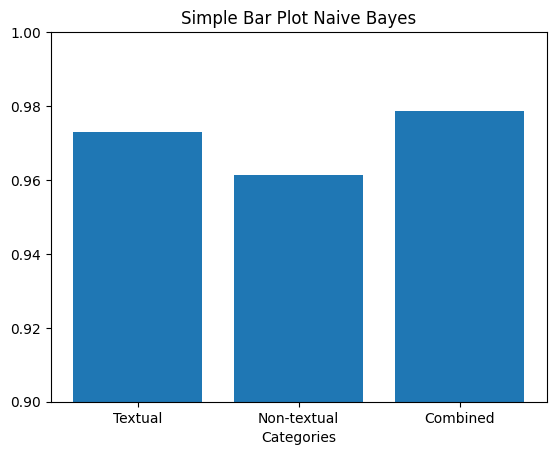

In [74]:
# Naive Bayes Algorithm
categories = ['Textual', 'Non-textual', 'Combined']
values = list(accuracy_data_NB.values())
plt.bar(categories, values)
plt.ylim(0.9, 1)
plt.xlabel('Categories')
plt.title("Simple Bar Plot Naive Bayes")
plt.show()

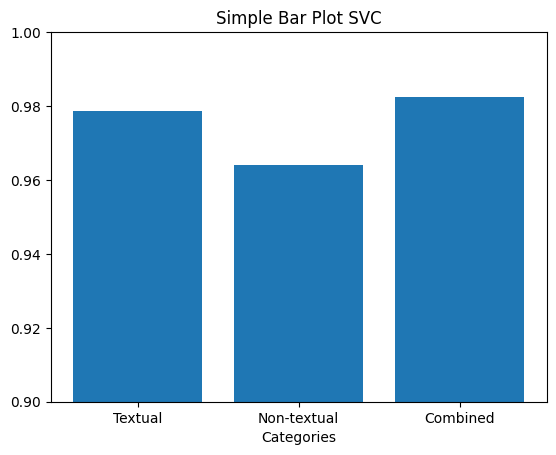

In [75]:
categories = ['Textual', 'Non-textual', 'Combined']
values = list(accuracy_data_SVC.values())
plt.bar(categories, values)
plt.ylim(0.9, 1)
plt.xlabel('Categories')
plt.title("Simple Bar Plot SVC")
plt.show()